Loading train dataset!
Number of classes: 11.
Data size: 7213.
 ---------- --------- ---------- 

Loading valid dataset!
Number of classes: 11.
Data size: 1543.
 ---------- --------- ---------- 

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_______________________________________________________________

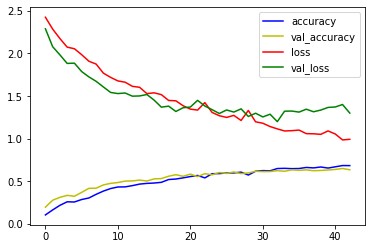

In [ ]:
# Deep Learning Fundamentals course
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pathlib
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint

# training parameters
batch_size = 128
img_size = 256
learning_rate = 0.001
num_epochs = 100
dropout = 0.5
patience = 10

def load_dataset(ds, mode):

  def process_path(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    label = tf.cast(one_hot, dtype='int64')  # Create labels
    img = tf.io.read_file(file_path)  # Read file
    img = tf.io.decode_jpeg(img, channels=3)  # Convert image to tensor
    img = tf.image.convert_image_dtype(img, tf.float32) # Normalize image in the range of 0 and 1
    img = tf.image.resize(img, [img_size, img_size])    # Resize the image
    return img, label

  def transformation(image, label):
    # Apply transformations to images 
    # the type of transformation (augmentations) used is different at train and evaluation time.
    if mode == 'train':  
      img = tf.image.central_crop(image, 0.7)
      img = tf.image.resize_with_pad(img, img_size, img_size)
      img = tf.clip_by_value(img, 0.0,1.0)    # To make sure images are in the range of 0 and 1 after transformations
      return img, label
    else:
      img = tf.clip_by_value(image, 0.0,1.0) 
      return img, label

  def configuration(dataset):
    # Configurations to optimize the performance
    dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    dataset = dataset.map(transformation, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size=batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset
  
  # Load and generate dataset
  data_dir = pathlib.Path("drive/MyDrive/dl/data/" + ds) # Specify the path to data folder
  image_count = len(list(data_dir.glob('*/*.jpg')))
  files_list = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
  files_list = files_list.shuffle(image_count, reshuffle_each_iteration=False)
  class_names = np.array(sorted([item.name for item in data_dir.glob('[!.]*')]))
  print("Loading {} dataset!".format(ds))
  print("Number of classes: {}.".format(len(class_names)))
  print("Data size: {}.".format(image_count))
  print(" ---------- --------- ---------- \n")
  return configuration(files_list)

# Prepare train and valid dataset
train = load_dataset(ds = 'train', mode='train')
valid = load_dataset(ds = 'valid', mode=None)

# Create your own model or import pretrained models and add your own layers
num_classes = 11

vgg16_model = tf.keras.applications.vgg16.VGG16(include_top = False, weights = 'imagenet', pooling = 'maxpooling', input_shape = (img_size, img_size, 3))
vgg16_model.summary()
vgg16_model_touse = tf.keras.models.Model(inputs = vgg16_model.input, outputs= vgg16_model.get_layer('block5_pool').output)
vgg16_model_touse.summary()

model = tf.keras.Sequential([
  vgg16_model_touse,
  tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu'),
  tf.keras.layers.Conv2D(1024, (3, 3), activation = 'relu'),
  tf.keras.layers.MaxPool2D(pool_size = (2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dropout(dropout),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(dropout),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(dropout),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(dropout),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

# exclude the initial layers
for layer in vgg16_model_touse.layers:
    layer.trainable = False

model.summary()

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9),
    loss = 'categorical_crossentropy',
    metrics=['accuracy'])

# Make sure to use h5 format to save model
callbacks = [EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='min'), 
            ModelCheckpoint(filepath='model.h5', verbose=1, monitor='val_loss', save_best_only=True, save_weights_only=False, mode='min')]

# data augmentation
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, horizontal_flip=True, shear_range=0.2, zoom_range=0.2, preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
train_ds = train_generator.flow_from_directory('drive/MyDrive/dl/data/train', target_size = (img_size,img_size), batch_size = 200, class_mode = 'categorical')
valid_ds = valid_generator.flow_from_directory('drive/MyDrive/dl/data/valid', target_size = (img_size,img_size), batch_size = 200, class_mode = 'categorical')

# train the model
history = model.fit(
  train_ds,
  epochs = num_epochs,
  validation_data = valid_ds,
  callbacks = callbacks
)

# checking the history
history_df = pd.DataFrame(history.history)
print(history_df)
history_csv_file = 'history.csv'
with open(history_csv_file, mode = 'w') as f:
  history_df.to_csv(history_csv_file)
history_toread = np.loadtxt('history.csv', delimiter = ',', skiprows = 1)
plt.plot(history.history['accuracy'], 'b-', label = 'accuracy')
plt.plot(history.history['val_accuracy'], 'y-', label = 'val_accuracy')
plt.plot(history.history['loss'], 'r-', label = 'loss')
plt.plot(history.history['val_loss'], 'g-', label = 'val_loss')
plt.legend()
plt.show()

In [ ]:
import json
batch_size = 32
img_size = 256

# Get class names and index in a dictionary
data_dir = pathlib.Path("drive/MyDrive/dl/data/train") # Specify the path to train data folder
d = {0: 'creamy_paste',
 1: 'diced',
 2: 'floured',
 3: 'grated',
 4: 'juiced',
 5: 'jullienne',
 6: 'mixed',
 7: 'other',
 8: 'peeled',
 9: 'sliced',
 10: 'whole'}

# Load test images
data_dir = pathlib.Path("drive/MyDrive/dl/data/test/test") # Specify the path to test data folder
image_count = len(list(data_dir.glob('*.jpg')))
files_list = tf.data.Dataset.list_files(str(data_dir/'*'), shuffle=False)
print("Loading test dataset \nData size: {}".format(image_count))

def process_path(file_path):
  img = tf.io.read_file(file_path)  # Read file
  img = tf.io.decode_jpeg(img, channels=3)  # Convert image to tensor
  img = tf.image.convert_image_dtype(img, tf.float32) # Normalize image in the range of 0 and 1
  img = tf.image.resize(img, [img_size, img_size])    # Resize the image
  return img

def transformation(image):
  # Apply transformations to images
  # the type of transformation (augmentations) used is different at train and evaluation time.

  img = tf.clip_by_value(image, 0.0,1.0)    # To make sure images are in the range of 0 and 1 after transformations
  return img

# Process test images
dataset = files_list.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.map(transformation, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(batch_size=batch_size)

# Load saved model
new_model = tf.keras.models.load_model("model.h5")

# Predict
pred = new_model.predict(dataset, verbose=1)
preds = np.argmax(pred, axis=1)

# Create dictionary of images and their predictions
dictionary = {}
count = 0
for i in files_list:
  path = i.numpy().decode('utf-8')
  dictionary.update({path[5:]:d[preds[count]]})
  count += 1

with open("results.json", "w") as outfile:
  json.dump(dictionary, outfile) 

print("Json file saved.")

Loading test dataset 
Data size: 2163
68/68 [==============================] - 145s 2s/step
Json file saved.
